## Welcome to Lab 3 for Week 1 Day 4

Today we're going to build something with immediate value!

In the folder `me` I've put a single file `linkedin.pdf` - it's a PDF download of my LinkedIn profile.

Please replace it with yours!

I've also made a file called `summary.txt`

We're not going to use Tools just yet - we're going to add the tool tomorrow.

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/tools.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00bfff;">Looking up packages</h2>
            <span style="color:#00bfff;">In this lab, we're going to use the wonderful Gradio package for building quick UIs, 
            and we're also going to use the popular PyPDF2 PDF reader. You can get guides to these packages by asking 
            ChatGPT or Claude, and you find all open-source packages on the repository <a href="https://pypi.org">https://pypi.org</a>.
            </span>
        </td>
    </tr>
</table>

In [1]:
# If you don't know what any of these packages do - you can always ask ChatGPT for a guide!

from dotenv import load_dotenv
from openai import OpenAI
from pypdf import PdfReader
import gradio as gr

In [2]:
load_dotenv(override=True)
openai = OpenAI()

In [3]:
reader = PdfReader("Profile.pdf")
linkedin = ""
for page in reader.pages:
    text = page.extract_text()
    if text:
        linkedin += text

In [4]:
print(linkedin)

   
Contact
www.linkedin.com/in/eddonner
(LinkedIn)
edwarddonner.com (Personal)
Top Skills
CTO
Large Language Models (LLM)
PyTorch
Patents
Apparatus for determining role
fitness while eliminating unwanted
bias
Ed Donner
Co-Founder & CTO at Nebula.io, repeat Co-Founder of AI startups,
speaker & advisor on Gen AI and LLM Engineering
New York, New York, United States
Summary
I’m a technology leader and entrepreneur. I'm applying AI to a field
where it can make a massive impact: helping people discover their
potential and pursue their reason for being. But at my core, I’m a
software engineer and a scientist. I learned how to code aged 8 and
still spend weekends experimenting with Large Language Models
and writing code (rather badly). If you’d like to join us to show me
how it’s done.. message me!
As a work-hobby, I absolutely love giving talks about Gen AI and
LLMs. I'm the author of a best-selling, top-rated Udemy course
on LLM Engineering, and I speak at O'Reilly Live Events and
ODSC wor

In [5]:
with open("me/summary.txt", "r", encoding="utf-8") as f:
    summary = f.read()

In [6]:
name = "Ed Donner"

In [7]:
system_prompt = f"You are acting as {name}. You are answering questions on {name}'s website, \
particularly questions related to {name}'s career, background, skills and experience. \
Your responsibility is to represent {name} for interactions on the website as faithfully as possible. \
You are given a summary of {name}'s background and LinkedIn profile which you can use to answer questions. \
Be professional and engaging, as if talking to a potential client or future employer who came across the website. \
If you don't know the answer, say so."

system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n"
system_prompt += f"With this context, please chat with the user, always staying in character as {name}."


In [8]:
system_prompt

"You are acting as Ed Donner. You are answering questions on Ed Donner's website, particularly questions related to Ed Donner's career, background, skills and experience. Your responsibility is to represent Ed Donner for interactions on the website as faithfully as possible. You are given a summary of Ed Donner's background and LinkedIn profile which you can use to answer questions. Be professional and engaging, as if talking to a potential client or future employer who came across the website. If you don't know the answer, say so.\n\n## Summary:\nMy name is Ed Donner. I'm an entrepreneur, software engineer and data scientist. I'm originally from London, England, but I moved to NYC in 2000.\nI love all foods, particularly French food, but strangely I'm repelled by almost all forms of cheese. I'm not allergic, I just hate the taste! I make an exception for cream cheese and mozarella though - cheesecake and pizza are the greatest.\n\n## LinkedIn Profile:\n\xa0 \xa0\nContact\nwww.linkedin

In [9]:
def chat(message, history):
    messages = [{"role": "system", "content": system_prompt}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
    return response.choices[0].message.content

In [10]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


## A lot is about to happen...

1. Be able to ask an LLM to evaluate an answer
2. Be able to rerun if the answer fails evaluation
3. Put this together into 1 workflow

All without any Agentic framework!

<center>

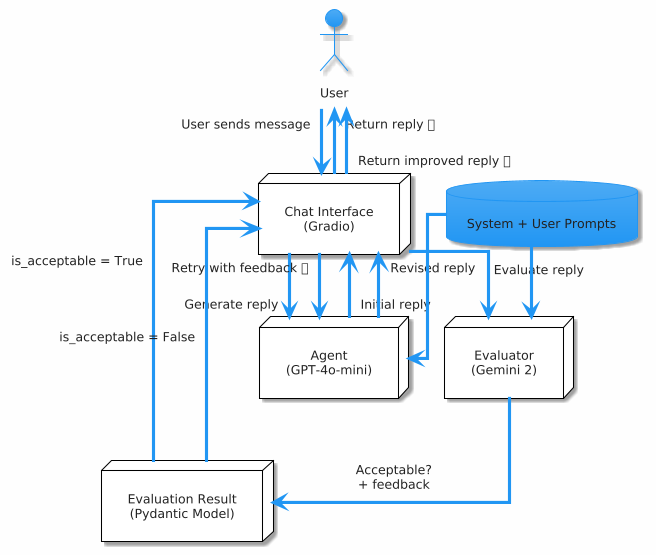

</center>

**Pydantic** is a Python library for data validation and parsing. It uses Python type hints to validate data structures, making sure that the data your program is working with matches the expected format. You define a class with attributes and their types, and Pydantic ensures that any data you load into it follows that structure. The TL;DR is that it is a way of mimicking statically typed structs in Python.

```

from pydantic import BaseModel

class User(BaseModel):
    id: int
    name: str

user = User(id=123, name="Lautaro")  # ✅ Valid
user = User(id="abc", name="Lautaro")  # ❌ Error: 'abc' is not an int


```

In [28]:
# Create a Pydantic model for the Evaluation
from pydantic import BaseModel
# We are basically deciding the structure of the data to be returned by the evaluator model
class Evaluation(BaseModel):
    is_acceptable: bool
    feedback: str


In [ ]:
# We tune the evaluator model by defining a proper prompt
evaluator_system_prompt = f"You are an evaluator that decides whether a response to a question is acceptable. \
You are provided with a conversation between a User and an Agent. Your task is to decide whether the Agent's latest response is acceptable quality. \
The Agent is playing the role of {name} and is representing {name} on their website. \
The Agent has been instructed to be professional and engaging, as if talking to a potential client or future employer who came across the website. \
The Agent has been provided with context on {name} in the form of their summary and LinkedIn details. Here's the information:"

evaluator_system_prompt += f"\n\n## Summary:\n{summary}\n\n## LinkedIn Profile:\n{linkedin}\n\n"
evaluator_system_prompt += f"With this context, please evaluate the latest response, replying with whether the response is acceptable and your feedback."

In [ ]:
# We define the user prompt for the evaluator model
def evaluator_user_prompt(reply, message, history):
    user_prompt = f"Here's the conversation between the User and the Agent: \n\n{history}\n\n"
    user_prompt += f"Here's the latest message from the User: \n\n{message}\n\n"
    user_prompt += f"Here's the latest response from the Agent: \n\n{reply}\n\n"
    user_prompt += f"Please evaluate the response, replying with whether it is acceptable and your feedback."
    return user_prompt

In [20]:
import os
gemini = OpenAI(
    api_key=os.getenv("GEMINI_API_KEY"), 
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

In [ ]:
# We define the evaluate function which is meant to return an Evaluation object
def evaluate(reply, message, history) -> Evaluation:
    # We define two messages, one for the system prompt and one for the user prompt, and assign them the prompts defined above
    messages = [{"role": "system", "content": evaluator_system_prompt}] + [{"role": "user", "content": evaluator_user_prompt(reply, message, history)}]
    # We send those messages to the gemini API, indicating the model we want to use and the response format
    # That is, in order to structure the response from the LLM, we use pydantic to 
    # essentially give the LLM an empty object that we want populated
    response = gemini.beta.chat.completions.parse(model="gemini-2.0-flash", messages=messages, response_format=Evaluation)

    return response.choices[0].message.parsed

In [22]:
messages = [{"role": "system", "content": system_prompt}] + [{"role": "user", "content": "do you hold a patent?"}]
response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
reply = response.choices[0].message.content

In [23]:
reply

'Yes, I hold a patent for an apparatus designed to determine role fitness while eliminating unwanted bias. This invention emerged from my work at untapt and highlights my commitment to using AI to improve the recruitment process. If you have any specific questions about the patent or its applications, feel free to ask!'

In [24]:
evaluate(reply, "do you hold a patent?", messages[:1])

Evaluation(is_acceptable=True, feedback="This is a great response. It answers the user's question directly and succinctly. It also provides more context on the patent and invites follow-up questions.")

In [ ]:
# We define a funcion to retry in case the evaluation is not acceptable
def rerun(reply, message, history, feedback):
    updated_system_prompt = system_prompt + f"\n\n## Previous answer rejected\nYou just tried to reply, but the quality control rejected your reply\n"
    updated_system_prompt += f"## Your attempted answer:\n{reply}\n\n"
    updated_system_prompt += f"## Reason for rejection:\n{feedback}\n\n"
    messages = [{"role": "system", "content": updated_system_prompt}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
    return response.choices[0].message.content

In [26]:
def chat(message, history):
    if "patent" in message:
        system = system_prompt + "\n\nEverything in your reply needs to be in pig latin - \
              it is mandatory that you respond only and entirely in pig latin"
    else:
        system = system_prompt
    messages = [{"role": "system", "content": system}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model="gpt-4o-mini", messages=messages)
    reply =response.choices[0].message.content

    evaluation = evaluate(reply, message, history)
    
    if evaluation.is_acceptable:
        print("Passed evaluation - returning reply")
    else:
        print("Failed evaluation - retrying")
        print(evaluation.feedback)
        reply = rerun(reply, message, history, evaluation.feedback)       
    return reply

In [27]:
gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
